In [3]:
from matplotlib import pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
from glob import glob
from tqdm.notebook import tqdm
import json

MIN_PASSES_IN_POSSESSION = 4

# Read the data
filenames = glob('data/plays_filtered/*.json')
possessions = []
for filename in tqdm(filenames[:20]):
    with open(filename, 'rb') as f:
        possessions_from_file = json.load(f)
    possessions.append(possessions_from_file)

possessions = [possession for possession_list in possessions for possession in possession_list]

len(possessions)

  0%|          | 0/20 [00:00<?, ?it/s]

1256

In [5]:
def draw_graph(G_attack: nx.Graph) -> None:
    # Draw the graph (must show node names and weights)
    pos = nx.spring_layout(G_attack)
    nx.draw(G_attack, pos, with_labels=True, connectionstyle='arc3,rad=0.1')
    
    edge_labels = nx.get_edge_attributes(G_attack, 'weight')
    nx.draw_networkx_edge_labels(G_attack, pos, edge_labels=edge_labels)

    plt.show()

In [26]:
# For each possession, create a directed graph from the passes in that possession.
# The nodes are the players, and the edges are the passes.
# The edge weight is the number of times that pass was made.

def compute_attacking_graph(possession, key):
    # Create the the attacking graph for this entire possession
    G_attack = nx.DiGraph()
    
    for pass_ in possession[key]:
        pass_from = pass_['pass_from'] or 'x'
        pass_to = pass_['pass_to'] or 'y'

        print(f'{pass_from} --> {pass_to}')

        # If this edge already exists, increase the weight by one, else add it
        if G_attack.has_edge(pass_from, pass_to):
            G_attack[pass_from][pass_to]['weight'] += 1
        else:
            G_attack.add_edge(pass_from, pass_to, weight=1)
    
    return G_attack


Chris Paul --> JJ Redick
Blake Griffin --> JJ Redick
JJ Redick --> Blake Griffin
JJ Redick --> Chris Paul
---
Chris Paul --> JJ Redick
Blake Griffin --> JJ Redick
JJ Redick --> Blake Griffin
JJ Redick --> Chris Paul


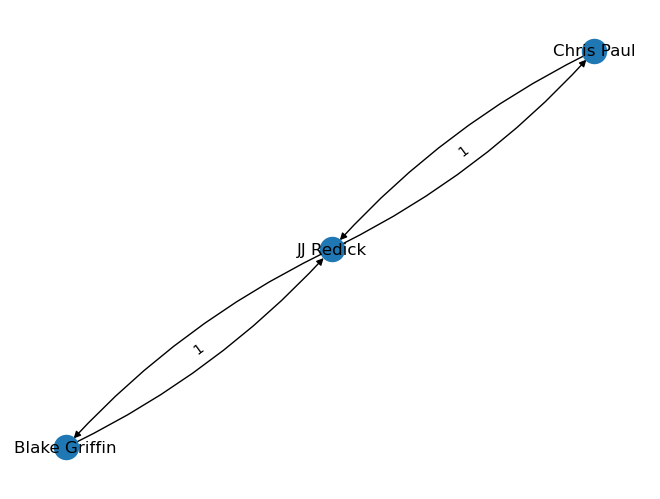

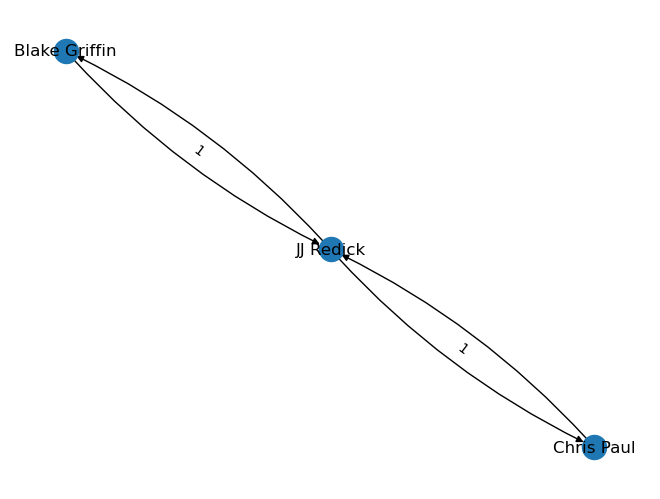

In [38]:
import random
i = random.randint(0, len(possessions))
ag1 = compute_attacking_graph(possessions[i], key='Passes')
print('---')
ag2 = compute_attacking_graph(possessions[i], key='CombinedPasses')

draw_graph(ag1)
draw_graph(ag2)

In [16]:
# Compute various metrics for the attacking graph

metric_labels_att = ['max_bwn_c', 'recip', 'triangles', 'numpasses']

def compute_metrics_on_attacking_graph(G_attack):
    results = pd.Series(index=metric_labels_att, dtype=float)
    results['max_bwn_c'] = max(nx.betweenness_centrality(G_attack).values())
    results['recip'] = nx.reciprocity(G_attack)
    results['triangles'] = sum(nx.triangles(nx.Graph(G_attack)).values()) // 3
    # sum of all edge weights
    results['numpasses'] = sum([G_attack[u][v]['weight'] for u, v in G_attack.edges()])
    
    return results

In [5]:
def compute_defending_team_for_possession(possession):
    #### Figure out which one is the defending team ####
    # Go through all the passes, see who made the pass, compute the team of this player, take the majority

    passee_team_for_each_pass = [] # "passee" = person who receives the pass
    
    for pass_ in possession['Passes']:
        
        snapshot = pass_['snapshots'][0]
        home_players = [player for player in snapshot['HomePlayers'].keys()]
        guest_players = [player for player in snapshot['GuestPlayers'].keys()]
        
        pass_to_team = None
        pass_to = pass_['pass_to']
        if pass_to in home_players:
            pass_to_team = 'home'
        elif pass_to in guest_players:
            pass_to_team = 'guest'
        else:
            pass_to_team = 'unknown'
        passee_team_for_each_pass.append(pass_to_team)
    
    defending_team = None

    # Sanity check: if this possession had equal-ish passees from both teams, then something is wrong
    passee_team_for_each_pass = pd.Series(passee_team_for_each_pass)
    num_home_passes = passee_team_for_each_pass.value_counts().get('home', 0)
    num_guest_passes = passee_team_for_each_pass.value_counts().get('guest', 0)
    if abs(num_home_passes - num_guest_passes) <= 2:
        defending_team = 'unknown'
    else:
        defending_team = passee_team_for_each_pass.value_counts().sort_values().index[0]

    return(defending_team)

In [6]:
def create_defensive_graphs_for_possession(possession):

    defending_team = compute_defending_team_for_possession(possession)
    if defending_team == 'unknown':
        return None

    # For each pass in the possession, get the defensive team's positions
    player_positions_key = 'HomePlayers' if defending_team == 'home' else 'GuestPlayers'
    defensive_graphs = []
    
    for pass_ in possession['Passes']:
        defending_team_positions = pass_['snapshots'][0][player_positions_key]
        ball_position = pass_['snapshots'][0]['Ball']

        # Create a graph with players as nodes and distance between them as edge lengths
        # Also add the ball as a node, and an edge between the ball and every player
        G = nx.Graph()
        G.add_node('ball')
        for player_name in defending_team_positions:
            G.add_node(player_name)
            # Add edge between this player and the ball
            player = defending_team_positions[player_name]
            distance = np.round(np.sqrt((player['x'] - ball_position['x'])**2 + (player['y'] - ball_position['y'])**2), 2)
            G.add_edge(player_name, 'ball', weight=distance)
        
        for player_name in defending_team_positions:
            player = defending_team_positions[player_name]
            for other_player_name in defending_team_positions:
                other_player = defending_team_positions[other_player_name]
                if player_name != other_player_name:
                    distance = np.round(np.sqrt((player['x'] - other_player['x'])**2 + (player['y'] - other_player['y'])**2), 2)
                    G.add_edge(player_name, other_player_name, weight=distance)
    
        # draw_graph(G)
        defensive_graphs.append(G)
    
    return defensive_graphs

In [7]:
# Compute various metrics for the defensive graph

metric_labels_def = ['max_pagerank', 'dist_from_ball', 'edge_sum'] # TODO: add more defensive metrics

def compute_metrics_on_defensive_graph(G_defense):
    results = pd.Series(index=metric_labels_def, dtype=float)
    results['max_pagerank'] = max(nx.pagerank(G_defense).values())
    results['dist_from_ball'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges() if u == 'ball']) / (G_defense.number_of_nodes()-1)
    # sum of all edge weights
    results['edge_sum'] = sum([G_defense[u][v]['weight'] for u, v in G_defense.edges()])
    
    return results

In [ ]:
# Create data for Jonathan

from networkx.readwrite import json_graph
import json

possessions_for_jonathan = []

for possession in tqdm(possessions):

    G_attack = compute_attacking_graph(possession)
    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    possession['attacking_graph'] = json_graph.node_link_data(G_attack)
    possession['defensive_graphs'] = [json_graph.node_link_data(G_defense) for G_defense in Gs_defense]

    possessions_for_jonathan.append(possession)

with open('data/possessions_for_jonathan.json', 'w') as f:
    json.dump(possessions_for_jonathan, f)

In [ ]:
# Try reading the data back in -- writing this function for Jonathan
def read_data_for_jonathan():
    with open('data/possessions_for_jonathan.json', 'r') as f:
        possessions_for_jonathan = json.load(f)
    
    for possession in possessions_for_jonathan:
        possession['attacking_graph'] = json_graph.node_link_graph(possession['attacking_graph'])
        possession['defensive_graphs'] = [json_graph.node_link_graph(G_defense) for G_defense in possession['defensive_graphs']]

    return possessions_for_jonathan

In [32]:
rows = []
used_possessions = []

for possession in tqdm(possessions):
    # If there's too few passes in this possession, skip it
    if len(possession['Passes']) < MIN_PASSES_IN_POSSESSION:
        continue

    # TODO: add counter and see how much data we're filtering out
    # TODO: give defensive data to Jonathan

    G_attack = compute_attacking_graph(possession)
    # draw_graph(G_attack)

    Gs_defense = create_defensive_graphs_for_possession(possession)
    if Gs_defense is None: # defending team is unknown
        continue
    
    # Now we have both graphs, we can compute metrics for both
    
    # Compute metrics for attacking graph
    metrics_att = compute_metrics_on_attacking_graph(G_attack)
    metrics_def = []

    # With defensive graphs, it's complicated because there are multiple graphs.
    # Let's compute metrics for the first, middle, and last graphs.
    assert MIN_PASSES_IN_POSSESSION >= 3
    n = len(Gs_defense)
    Gs_defense = [Gs_defense[0], Gs_defense[n//2], Gs_defense[-1]]
    for (i, G_defense) in enumerate(Gs_defense):
        metrics_def_i = compute_metrics_on_defensive_graph(G_defense)
        metrics_def_i.index = metrics_def_i.index + f'_{i}'
        metrics_def.append(metrics_def_i)
        # draw_graph(G_defense)
    
    metrics_def = pd.concat(metrics_def)
    row = pd.concat([metrics_att, metrics_def])
    # Add the label
    row['label'] = possession['Weight']
    rows.append(row)
    used_possessions.append(possession)
    

  0%|          | 0/314 [00:00<?, ?it/s]

LeBron James --> Kevin Love
x --> Kevin Love
Kevin Love --> Kyrie Irving
Kyrie Irving --> J.R. Smith
J.R. Smith --> Tristan Thompson
Tristan Thompson --> LeBron James
LeBron James --> Kyrie Irving
Kyrie Irving --> LeBron James
LeBron James --> Marcin Gortat


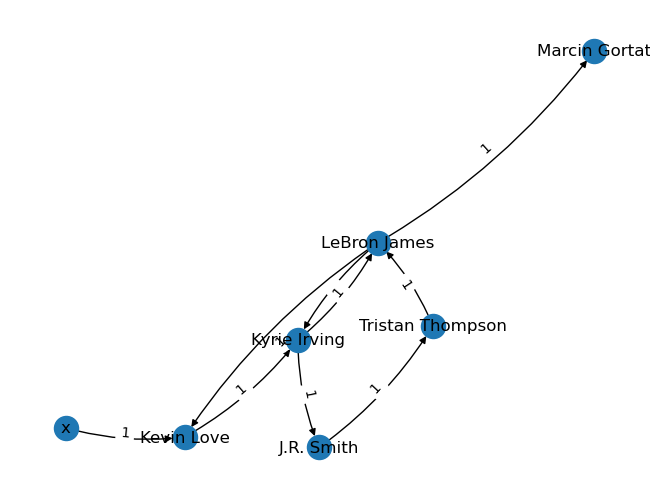

/Users/agdhruv/opt/anaconda3/envs/myenv/lib/python3.9/site-packages/networkx/drawing/nx_pylab.py:304: UserWarning: 

The connectionstyle keyword argument is not applicable when drawing edges
with LineCollection.

To make this warning go away, either specify `arrows=True` to
force FancyArrowPatches or use the default value for connectionstyle.
Note that using FancyArrowPatches may be slow for large graphs.

  draw_networkx_edges(G, pos, arrows=arrows, **edge_kwds)


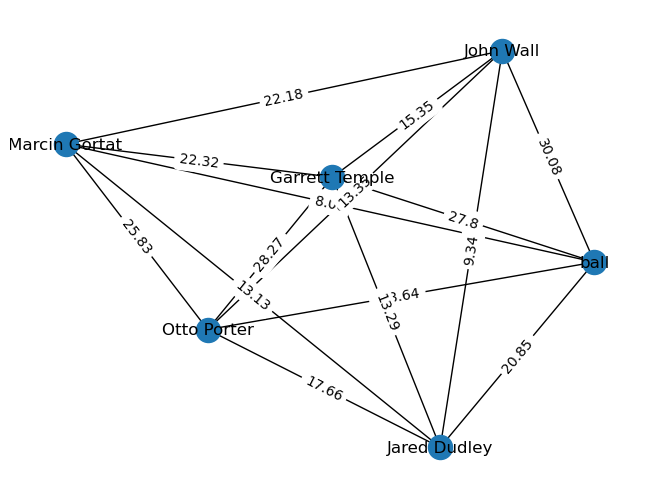

In [292]:
# TODO: The possession data need to be cleaned and/or manually validated. See the graphs below, some of them don't make sense.
#       1) Sometimes `pass_from` is None. What does that mean?
#       2) Sometimes, the defensive player appears in the attacking graph.
#          Is that okay or should we remove defensive players from the attacking graph?
#       3) In 5 games, there are only 85 filtered possessions with more than 4 passes? That seems wrong.

import random

i = random.randint(0, len(used_possessions))
poss = used_possessions[i]
a = compute_attacking_graph(poss)
d = create_defensive_graphs_for_possession(poss)

draw_graph(a)
draw_graph(d[0])

In [33]:
df = pd.DataFrame(rows)
df

,max_bwn_c,recip,triangles,numpasses,max_pagerank_0,dist_from_ball_0,edge_sum_0,max_pagerank_1,dist_from_ball_1,edge_sum_1,max_pagerank_2,dist_from_ball_2,edge_sum_2,label
0,0.333333,0.400000,0.0,6.0,0.212229,18.150,285.48,0.200725,24.968,354.83,0.239039,16.268,335.96,2.0
1,0.214286,0.222222,1.0,9.0,0.209714,29.848,346.59,0.216425,27.256,305.29,0.241944,8.852,157.95,-1.0
2,0.333333,0.500000,0.0,4.0,0.201421,18.112,317.81,0.197838,24.864,418.17,0.193781,22.622,389.43,2.0
3,0.428571,0.000000,1.0,9.0,0.208932,26.104,337.83,0.227064,10.188,204.98,0.195087,22.714,284.52,2.0
4,0.500000,0.800000,0.0,5.0,0.185735,29.494,437.74,0.203200,21.750,261.03,0.232281,11.934,239.79,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,0.366667,0.222222,1.0,9.0,0.195738,24.090,301.17,0.199039,17.510,275.68,0.276945,16.116,287.75,3.0
81,0.366667,0.250000,1.0,9.0,0.245146,26.486,509.50,0.229455,25.422,326.09,0.254059,12.876,257.97,3.0
82,0.500000,0.000000,1.0,4.0,0.262629,20.438,436.05,0.204519,27.292,401.85,0.237607,20.572,369.05,3.0
83,0.466667,0.666667,0.0,10.0,0.246287,36.536,355.46,0.202820,17.984,265.81,0.265094,10.372,194.43,3.0


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, classification_report, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

# Split the data into predictor variables (X) and label (y)
X = df.iloc[:, :len(metric_labels_att) + len(metric_labels_def)]
y = df['label']

# Split the data into training and testing sets with a 90-10 split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Scale the data
# TODO: What is this doing?
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create the classification model
classification_model = LogisticRegression(multi_class='multinomial', solver='lbfgs')

# Fit the model to the training data
classification_model.fit(X_train_scaled, y_train)

# Predict the labels for the test data
y_pred = classification_model.predict(X_test_scaled)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
classification_report = classification_report(y_test, y_pred)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{classification_report}")

# TODO: how to interpret this classification report?

Accuracy: 0.5555555555555556
Classification Report:
              precision    recall  f1-score   support

         2.0       0.50      1.00      0.67         4
         3.0       1.00      0.20      0.33         5

    accuracy                           0.56         9
   macro avg       0.75      0.60      0.50         9
weighted avg       0.78      0.56      0.48         9



In [218]:
# Get the coefficients
coefficients = classification_model.coef_

# Create a DataFrame for easy viewing
coeff_df = pd.DataFrame(coefficients, columns=X.columns)

# Transpose the DataFrame for easier viewing
coeff_df = coeff_df.T

# Add the class labels as column names
coeff_df.columns = classification_model.classes_

# Print the DataFrame
coeff_df

# TODO: How to interpret the coefficients?
# TODO: Are the features significant predictors?
# TODO: Should we try making this a binary classification problem?

,-2.0,-1.0,1.0,2.0,3.0
max_bwn_c,0.160628,0.028434,-0.876955,0.170394,0.517498
recip,-0.095529,0.215969,0.209987,-0.059039,-0.271388
triangles,-0.293837,0.276055,-0.353101,0.404330,-0.033447
numpasses,1.185624,-0.142029,-0.440741,-0.309783,-0.293071
max_pagerank,-0.026690,-0.032525,0.348787,-0.296696,0.007124
dist_from_ball,-0.408792,0.290584,0.645641,-0.658531,0.131098
edge_sum,0.215142,-0.535185,0.173630,0.288247,-0.141835


In [ ]:
import statsmodels.api as sm

# Add a constant to the features
X2 = sm.add_constant(X)

# Fit the model
model = sm.Logit(y, X2)
result = model.fit()

# Print the summary table
print(result.summary())

Linear regression code below. Not using this anymore.

In [160]:
# Create the regression model -- Not using this anymore
regression_model = LinearRegression()
regression_model.fit(X_train, y_train)
y_pred = regression_model.predict(X_test)

# The coefficients
print("Coefficients: \n", regression_model.coef_)

# The mean squared error
print(f"Mean squared error: {mean_squared_error(y_test, y_pred)}")
# The coefficient of determination: 1 is perfect prediction
print(f"Coefficient of determination: {r2_score(y_test, y_pred)}")


Coefficients: 
 [ 1.10778542 -0.02303467 -0.03623196 -0.22364288]
Mean squared error: 3.045934892439289
Coefficient of determination: -0.923748353119551
